### Библиотеки


In [1]:
#!pip freeze > requirements.txt

In [2]:
#!pip install -r requirements.txt

In [3]:
#!pip install implicit
#!pip install sentence_transformers
#!pip install lightfm
#!pip install annoy

In [4]:
import pandas as pd
import implicit
import lightfm
import scipy
import re
import string
import annoy
import numpy as np
import torch
from torch import optim, nn
import random
import warnings
from collections import Counter
from typing import List, Tuple

import torch
from torch import nn, optim
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

c:\Users\minik\anaconda3\envs\NLP\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


### Разведывательный анализ

In [5]:
check = pd.read_csv("C:/Users/minik/Desktop/RecSys/check.csv")
check.head()

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
0,2018-12-07,1260627,1455.0,168308.0,(197312) Пакет-майка 25см х 45см,906.0,205.0,-1.0,"1,00"
1,2018-12-07,198287,279.0,134832.0,(62448) Перекись водорода р-р наружн. 3% фл.по...,404.0,93.0,-1.0,"1,00"
2,2018-12-07,2418385,848.0,101384.0,(72183) Салициловая кислота р-р спирт 2% фл 40...,404.0,93.0,-1.0,"1,00"
3,2018-12-07,1285774,1511.0,168570.0,(197309) Пакет 28см х 50см,906.0,205.0,-1.0,"1,00"
4,2018-12-07,1810323,1501.0,168319.0,(197310) Пакет 30см х 60см,906.0,205.0,-1.0,"1,00"


In [6]:
#Сокращаем количество строк для ускорения работы до 500тыс.
check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000003 entries, 0 to 20000002
Data columns (total 9 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   sale_date_date           object 
 1   contact_id               object 
 2   shop_id                  float64
 3   product_id               float64
 4   name                     object 
 5   product_sub_category_id  float64
 6   product_category_id      float64
 7   brand_id                 float64
 8   quantity                 object 
dtypes: float64(5), object(4)
memory usage: 1.3+ GB


In [7]:
check.isna().value_counts()

sale_date_date  contact_id  shop_id  product_id  name   product_sub_category_id  product_category_id  brand_id  quantity
False           False       False    False       False  False                    False                False     False       19989262
                                                 True   False                    False                False     False          10738
True            True        True     True        True   True                     True                 True      True               2
False           False       True     True        True   True                     True                 True      True               1
dtype: int64

In [8]:
check = check.dropna()

check = check.drop_duplicates()

check = check.rename(columns={'sale_date_date': 'date'})

check['date'] = check['date'].astype('datetime64[ns]')

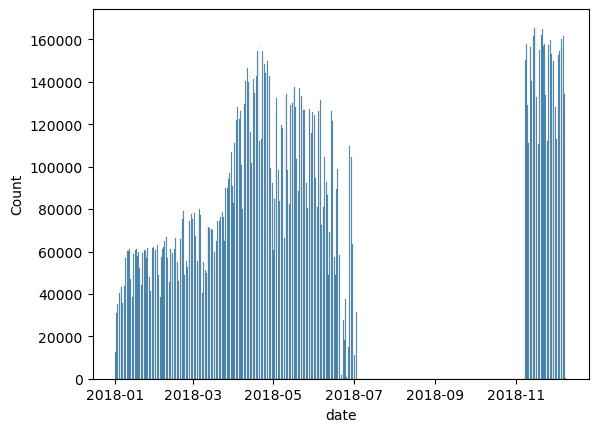

In [9]:
import seaborn as sns
date_plot = sns.histplot(
    data=check,
    x='date'
)

# Данные взяты за 2018 год, мы видим, что большинство покупок приходится на осенне-зимнее время(с 11 по 12 месяц), а также на весну(с 3 по 6 месяц)

In [10]:
# Посмотрим какие товары чаще берут
check['name'].value_counts()[:50]

(48791) Свободная сумма НДС18% (служебный)                                  147580
(197312) Пакет-майка 25см х 45см                                            117367
(181542) Карта Забота о Здоровье                                             88411
(57733) Корвалол капли д/приема внутрь 25мл                                  85714
(117825) Панангин таб.п.п.о.№50                                              76555
(81509) PL Хлоргексидин биглюконат р-р 0.05% фл.100мл №1 (НДС 18%)           72925
(20116) Тауфон капли глазн 4% фл 10 мл. пласт. флак.-кап.                    68046
(70458) Пенталгин таб.п.п.о.№24 (без кодеина)                                67709
(118125) Кардиомагнил таб.п.п.о.75мг №100                                    66565
(180739) Омепразол-Акрихин капс.кишечнораст.20мг №30                         66083
(33387) Троксевазин гель 2% туба 40г N1                                      60595
(46032) Омез капс 20мг N30                                                   57998
(395

In [11]:
check = check[check['name']!='(110047795) название']

In [12]:
check = check[check['name']!='(110048034) название']

###  Препроцессинг, построение эмбендингов Word2Vec


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
#Recommendation systems
from implicit.evaluation import mean_average_precision_at_k
from implicit.nearest_neighbours import CosineRecommender
import scipy

In [15]:
#For Bert
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

In [16]:
#For Word2Vec
from tqdm import tqdm
from gensim.models import Word2Vec

In [17]:
date_count = check['date'].value_counts().reset_index()

In [18]:
check['date'].astype('datetime64[ns]').dt.month.value_counts()
#Отсутствуют 8,9,10 месяца. Всего 9 месяцев представлено.

4     3828403
5     3515824
11    3391881
3     2253915
6     2219280
2     1712636
1     1540260
12    1161250
7       42537
Name: date, dtype: int64

In [19]:
# В данном случае лучше бы выбрать с каждого месяца по несколько покупок, чтобы предсказания не были только для сезонных заболеваний 

In [20]:
check['month_date'] = check['date'].astype('datetime64[ns]').dt.month
check

,date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity,month_date
0,2018-12-07,1260627,1455.0,168308.0,(197312) Пакет-майка 25см х 45см,906.0,205.0,-1.0,"1,00",12
1,2018-12-07,198287,279.0,134832.0,(62448) Перекись водорода р-р наружн. 3% фл.по...,404.0,93.0,-1.0,"1,00",12
2,2018-12-07,2418385,848.0,101384.0,(72183) Салициловая кислота р-р спирт 2% фл 40...,404.0,93.0,-1.0,"1,00",12
3,2018-12-07,1285774,1511.0,168570.0,(197309) Пакет 28см х 50см,906.0,205.0,-1.0,"1,00",12
4,2018-12-07,1810323,1501.0,168319.0,(197310) Пакет 30см х 60см,906.0,205.0,-1.0,"1,00",12
...,...,...,...,...,...,...,...,...,...,...
19999995,2018-06-13,1601618,1499.0,66842.0,(111992) Кэа Хэлс Ромашка [цветки фильтр-пакет...,615.0,140.0,1838.0,"1,00",6
19999996,2018-06-13,1394104,1495.0,136795.0,(97857) Лориста Н таб. п.о. 50мг+12.5мг №90,738.0,170.0,-1.0,"1,00",6
19999997,2018-06-13,1570654,1516.0,119513.0,(25299) Локрен тб п/о 20мг N28,738.0,170.0,-1.0,"1,00",6
19999998,2018-06-13,1924036,1485.0,71723.0,(60907) Тералиджен табл. п.п.о. 5 мг №25,637.0,146.0,-1.0,"1,00",6


In [21]:
month_list=list(check['month_date'].unique())

In [22]:
month_list

[12, 11, 1, 2, 3, 4, 5, 6, 7]

In [23]:
#Беру 200 тыс. записей только потому что на это хватает ресурсов.
#С учетом того,что у нас 9 месяцев всего, то из каждого нужно вытянуть ~ 20 тыс. покупок
num_sales = 20000
check_200 = pd.DataFrame(columns=check.columns)
for i in month_list:
    month = check[check['month_date']==i][:num_sales]
    check_200 = pd.concat([check_200, month], ignore_index=True)

check_200

,date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity,month_date
0,2018-12-07,1260627,1455.0,168308.0,(197312) Пакет-майка 25см х 45см,906.0,205.0,-1.0,"1,00",12
1,2018-12-07,198287,279.0,134832.0,(62448) Перекись водорода р-р наружн. 3% фл.по...,404.0,93.0,-1.0,"1,00",12
2,2018-12-07,2418385,848.0,101384.0,(72183) Салициловая кислота р-р спирт 2% фл 40...,404.0,93.0,-1.0,"1,00",12
3,2018-12-07,1285774,1511.0,168570.0,(197309) Пакет 28см х 50см,906.0,205.0,-1.0,"1,00",12
4,2018-12-07,1810323,1501.0,168319.0,(197310) Пакет 30см х 60см,906.0,205.0,-1.0,"1,00",12
...,...,...,...,...,...,...,...,...,...,...
179995,2018-07-03,590778,43.0,35413.0,(61456) Октолипен капс.300мг №30,596.0,135.0,-1.0,"1,00",7
179996,2018-07-03,591060,57.0,146664.0,(116895) Беталок ЗОК таб.п.о.замедл.высв.50мг ...,738.0,170.0,-1.0,"1,00",7
179997,2018-07-03,2072162,347.0,95045.0,"(61449) Снуп спрей наз. 0,1% фл.15мл",701.0,162.0,-1.0,"1,00",7
179998,2018-07-03,640422,317.0,72256.0,(4686) Протефикс активное ср-во для чистки про...,533.0,121.0,432.0,"1,00",7


In [24]:
check_200 = check_200.drop(columns=['month_date'])

In [25]:
check_200.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     180000 non-null  datetime64[ns]
 1   contact_id               180000 non-null  object        
 2   shop_id                  180000 non-null  float64       
 3   product_id               180000 non-null  float64       
 4   name                     180000 non-null  object        
 5   product_sub_category_id  180000 non-null  float64       
 6   product_category_id      180000 non-null  float64       
 7   brand_id                 180000 non-null  float64       
 8   quantity                 180000 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 12.4+ MB


In [26]:
check_200['quantity'] = check_200['quantity'].astype(str)


In [27]:
check_200['quantity'].value_counts()

1,00     130312
2,00      21623
3,00       8080
5,00       4126
4,00       3574
          ...  
0,854         1
1,58          1
31,00         1
0,036         1
0,267         1
Name: quantity, Length: 292, dtype: int64

In [28]:
check_200['quantity'] = check_200['quantity'].apply(lambda x: re.sub(r'[,]', '.', x))
check_200['quantity'] = check_200['quantity'].astype(np.float64)

In [29]:
float_columns = ['shop_id','product_id','product_sub_category_id','product_category_id','brand_id','quantity']
check_200[float_columns] = check_200[float_columns].astype(np.int64)

In [30]:
check_200['contact_id'] = check_200['contact_id'].astype(np.int64)

In [31]:
check_200.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     180000 non-null  datetime64[ns]
 1   contact_id               180000 non-null  int64         
 2   shop_id                  180000 non-null  int64         
 3   product_id               180000 non-null  int64         
 4   name                     180000 non-null  object        
 5   product_sub_category_id  180000 non-null  int64         
 6   product_category_id      180000 non-null  int64         
 7   brand_id                 180000 non-null  int64         
 8   quantity                 180000 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 12.4+ MB


In [32]:
# теперь необходимо преобразовать столбец name
# нужно убрать код товара
check_200['name']

0                          (197312) Пакет-майка 25см х 45см
1         (62448) Перекись водорода р-р наружн. 3% фл.по...
2         (72183) Салициловая кислота р-р спирт 2% фл 40...
3                                (197309) Пакет 28см х 50см
4                                (197310) Пакет 30см х 60см
                                ...                        
179995                     (61456) Октолипен капс.300мг №30
179996    (116895) Беталок ЗОК таб.п.о.замедл.высв.50мг ...
179997                 (61449) Снуп спрей наз. 0,1% фл.15мл
179998    (4686) Протефикс активное ср-во для чистки про...
179999                   (33852) Троксевазин капс.300мг №50
Name: name, Length: 180000, dtype: object

In [33]:
# Убираем код товара и выносим его в отдельный столбец и меняем на числовое значение
check_200['name_id'] = check_200['name'].apply(lambda x: re.findall(r'[^()]+', x)[0])
check_200['name'] = check_200['name'].apply(lambda x: re.sub(r'^[(]\w+[)]', '', x))
#check_200['name_id'] = check_200['name_id'].astype(np.int64) # При выполнении кода встречаем сложный код 


In [34]:
# Проверяем по ошибке и убираем его из выборки (в выборке их два)
check_200 = check_200[check_200['name_id']!='471df250-3bb9-11e7-8157-00155d5ea771']
check_200 = check_200[check_200['name_id']!='11467ae0-6317-11e7-815d-00155d5ea7a0']

In [35]:
check_200['name_id'] = check_200['name_id'].astype(np.int8)

In [36]:
check_200.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179998 entries, 0 to 179999
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     179998 non-null  datetime64[ns]
 1   contact_id               179998 non-null  int64         
 2   shop_id                  179998 non-null  int64         
 3   product_id               179998 non-null  int64         
 4   name                     179998 non-null  object        
 5   product_sub_category_id  179998 non-null  int64         
 6   product_category_id      179998 non-null  int64         
 7   brand_id                 179998 non-null  int64         
 8   quantity                 179998 non-null  int64         
 9   name_id                  179998 non-null  int8          
dtypes: datetime64[ns](1), int64(7), int8(1), object(1)
memory usage: 13.9+ MB


In [37]:
##Transactions identificator
check_200['transaction'] = check_200['date'].astype(str) + check_200['shop_id'].astype(str) + check_200['contact_id'].astype(str)

In [38]:
#Optimal positions
check_200 = check_200.reindex(columns = ['date',
                                 'transaction',
                                 'contact_id',
                                 'shop_id',
                                 'product_id',
                                 'name_id',
                                 'product_category_id',
                                 'product_sub_category_id',
                                 'brand_id',
                                 'quantity',
                                 'name'])

In [39]:
check_200

,date,transaction,contact_id,shop_id,product_id,name_id,product_category_id,product_sub_category_id,brand_id,quantity,name
0,2018-12-07,2018-12-0714551260627,1260627,1455,168308,-64,205,906,-1,1,Пакет-майка 25см х 45см
1,2018-12-07,2018-12-07279198287,198287,279,134832,-16,93,404,-1,1,Перекись водорода р-р наружн. 3% фл.полимерн....
2,2018-12-07,2018-12-078482418385,2418385,848,101384,-9,93,404,-1,1,Салициловая кислота р-р спирт 2% фл 40мл N1
3,2018-12-07,2018-12-0715111285774,1285774,1511,168570,-67,205,906,-1,1,Пакет 28см х 50см
4,2018-12-07,2018-12-0715011810323,1810323,1501,168319,-66,205,906,-1,1,Пакет 30см х 60см
...,...,...,...,...,...,...,...,...,...,...,...
179995,2018-07-03,2018-07-0343590778,590778,43,35413,16,135,596,-1,1,Октолипен капс.300мг №30
179996,2018-07-03,2018-07-0357591060,591060,57,146664,-97,170,738,-1,1,Беталок ЗОК таб.п.о.замедл.высв.50мг №30 флакон
179997,2018-07-03,2018-07-033472072162,2072162,347,95045,9,162,701,-1,1,"Снуп спрей наз. 0,1% фл.15мл"
179998,2018-07-03,2018-07-03317640422,640422,317,72256,78,121,533,432,1,Протефикс активное ср-во для чистки протезов ...


In [40]:
check_200['transaction'].value_counts().to_frame(name='transaction')

,transaction
2018-03-01849855245,51
2018-03-01316665607,47
2018-03-01313704966,46
2018-03-01348310286,42
2018-07-032641068998,40
...,...
2018-01-0815241470376,1
2018-01-0814611797115,1
2018-01-0815171266445,1
2018-01-0814611800538,1


In [41]:
transactions_sorted = check_200['transaction'].value_counts().sort_values(ascending=False).to_frame(name='transaction')
transactions_sorted = transactions_sorted.rename(columns={'transaction': 'count_trans'})

In [42]:
transactions_sorted['transaction'] = transactions_sorted.index
transactions_sorted = transactions_sorted.reset_index(drop=True)

In [43]:
transactions_sorted

,count_trans,transaction
0,51,2018-03-01849855245
1,47,2018-03-01316665607
2,46,2018-03-01313704966
3,42,2018-03-01348310286
4,40,2018-07-032641068998
...,...,...
96154,1,2018-05-0415041694881
96155,1,2018-05-0415061705530
96156,1,2018-05-0414691353031
96157,1,2018-05-0415161304568


In [44]:
# Выберем там, где больше двух товаров - чтобы избежать однородные рекомендации
transactions_sorted = transactions_sorted[transactions_sorted['count_trans']>=2]
transactions_sorted.describe()

,count_trans
count,37842.000000
mean,3.215501
std,2.080472
min,2.000000
25%,2.000000
50%,2.000000
75%,4.000000
max,51.000000


In [45]:
transactions_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37842 entries, 0 to 37841
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   count_trans  37842 non-null  int64 
 1   transaction  37842 non-null  object
dtypes: int64(1), object(1)
memory usage: 886.9+ KB


In [46]:
transactions_sorted

,count_trans,transaction
0,51,2018-03-01849855245
1,47,2018-03-01316665607
2,46,2018-03-01313704966
3,42,2018-03-01348310286
4,40,2018-07-032641068998
...,...,...
37837,2,2018-04-0415261408222
37838,2,2018-04-0414631842151
37839,2,2018-04-0414701350003
37840,2,2018-04-0414751468916


<Axes: >

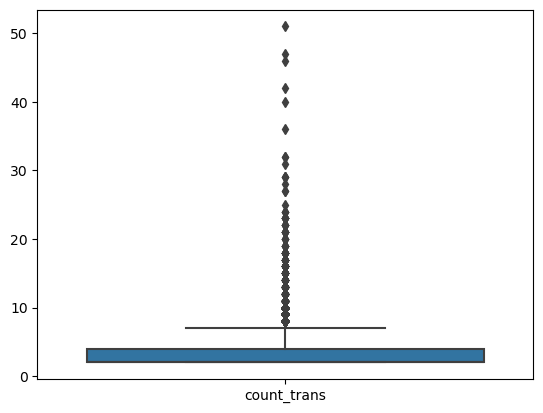

In [47]:
import seaborn as sns
sns.boxplot(
    data=transactions_sorted
)
# выбросы начинаются с 10 товаров 

In [48]:
# Поэтому мы уберем те транзакции, в которых больше 10 продуктов

transactions_sorted = transactions_sorted[transactions_sorted['count_trans'] < 10]


In [49]:
#Receive a list of transactions, by the numbers of which we will form the final dataset for further training
transactions_sorted = list(transactions_sorted['transaction'])

In [50]:
#Form the final dataset of a suitable shape  with a sales history for further work
check_200 = check_200.loc[check_200['transaction'].isin(transactions_sorted)]
check_200  = check_200 .drop_duplicates()
check_200.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112774 entries, 27 to 179999
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     112774 non-null  datetime64[ns]
 1   transaction              112774 non-null  object        
 2   contact_id               112774 non-null  int64         
 3   shop_id                  112774 non-null  int64         
 4   product_id               112774 non-null  int64         
 5   name_id                  112774 non-null  int8          
 6   product_category_id      112774 non-null  int64         
 7   product_sub_category_id  112774 non-null  int64         
 8   brand_id                 112774 non-null  int64         
 9   quantity                 112774 non-null  int64         
 10  name                     112774 non-null  object        
dtypes: datetime64[ns](1), int64(7), int8(1), object(2)
memory usage: 9.6+ MB


In [51]:
#Users & Items counting
users = len(check_200.contact_id.unique())
print("Количество уникальных пользователей в датасете:", users)
products = len(check_200.product_id.unique())
print("Количество уникальных продуктов в датасете:", products)

Количество уникальных пользователей в датасете: 35776
Количество уникальных продуктов в датасете: 10704


In [52]:
# Так как данные уже выбраны по датам, то делим классически по схеме 80/20
train, test = train_test_split(check_200, test_size=0.2, shuffle=False)

### Пробую ТОП10 и Word2Vec


Топ-10

In [53]:

baseline_top_10 = check_200.copy()
top_10 = list(baseline_top_10['product_id'].value_counts().index)[:10]
print(top_10)

top_10_products = baseline_top_10.loc[
    baseline_top_10['product_id'
].isin(top_10)][['product_id', 'name']].drop_duplicates()

print(top_10_products)


[168308, 158600, 41096, 39811, 137539, 110629, 134832, 135427, 31212, 32834]
       product_id                                               name
28         110629                Корвалол капли д/приема внутрь 25мл
34          39811     PL Салфетка антисептическая спиртовая 3х6см №1
38         158600                PL Шприц одноразовый 3-комп. 5мл №1
95         135427   Тауфон капли глазн 4% фл 10 мл. пласт. флак.-...
260         41096   PL Хлоргексидин биглюконат р-р 0.05% фл.100мл...
263        134832   Перекись водорода р-р наружн. 3% фл.полимерн....
719        137539                             Панангин таб.п.п.о.№50
1774        32834                                 Омез капс 20мг N30
2415        31212                   Кардиомагнил таб.п.п.о.75мг №100
15286      168308                            Пакет-майка 25см х 45см


In [54]:
test_baseline = baseline_top_10.sample(10)

test_products = list(test_baseline['product_id'])
test_products

[114395, 83201, 156599, 115626, 77238, 139747, 47063, 83424, 98400, 97275]

In [55]:

top_10 = set(top_10)

test_products = set(test_products)
intersection = set.intersection(top_10, test_products)
intersection = len(intersection)

# Качество по банальной метрики попадания продуктов из топ-10 в чек

precision = intersection/len(test_products)

precision

0.0

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90219 entries, 27 to 143476
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     90219 non-null  datetime64[ns]
 1   transaction              90219 non-null  object        
 2   contact_id               90219 non-null  int64         
 3   shop_id                  90219 non-null  int64         
 4   product_id               90219 non-null  int64         
 5   name_id                  90219 non-null  int8          
 6   product_category_id      90219 non-null  int64         
 7   product_sub_category_id  90219 non-null  int64         
 8   brand_id                 90219 non-null  int64         
 9   quantity                 90219 non-null  int64         
 10  name                     90219 non-null  object        
dtypes: datetime64[ns](1), int64(7), int8(1), object(2)
memory usage: 7.7+ MB


Косинусное расстояние

In [57]:
# Построим матрицы схожести item-to-item, обсуловлено это тем, что для заболевания
# необходимо рекоендовать товары с похожим механизмом действия 
# К тому же user-item сделать в нашем случае достаточно сложно

train_pivot = pd.pivot_table(
    train,
    index="transaction",
    columns="product_id",
    values="quantity"
)
test_pivot = pd.pivot_table(
    test,
    index="transaction",
    columns="product_id",
    values="quantity"
)


In [58]:

shell = pd.pivot_table(
    train,
    index="transaction",
    columns="product_id",
    values="quantity",
    aggfunc=lambda x: 0
)

train_pivot = shell + train_pivot
test_pivot = shell + test_pivot

train_pivot = (train_pivot + 1).fillna(0)
test_pivot = (test_pivot + 1).fillna(0)


In [59]:

train_pivot_sparse = scipy.sparse.csr_matrix(train_pivot.values)
test_pivot_sparse = scipy.sparse.csr_matrix(test_pivot.values)

In [60]:
# Посмотрим по векторной близости методом косинусов
cosine = CosineRecommender(K=10)
cosine.fit(train_pivot_sparse.T)

  0%|          | 0/30846 [00:00<?, ?it/s]

In [61]:

map_at10 = mean_average_precision_at_k(cosine, train_pivot_sparse, test_pivot_sparse, K=10)
print('Mean Average Precision at 10: {:.3f}'.format(map_at10))

  0%|          | 0/14 [00:00<?, ?it/s]

Mean Average Precision at 10: 0.000


Как мы видим модель по косинусу дает не очень хорошие рекомендации

Попробуем модель Word2Vec

In [62]:

sales_word2vec = check_200.copy()
sales_word2vec = sales_word2vec.drop_duplicates()

need_cols = ['transaction', 'product_id', 'name']
sales_word2vec = sales_word2vec[need_cols].reset_index(drop=True)
sales_word2vec.dropna()
sales_word2vec.info()

#Преобразуемм product_id в str
sales_word2vec['product_id']= sales_word2vec['product_id'].astype(str)

#
transactions = list(sales_word2vec['transaction'].unique())

#Сделаем лист уникальных транзакций
purchases = []

for i in tqdm(transactions):
    temp = sales_word2vec.loc[sales_word2vec['transaction'] == i]['product_id'].tolist()
    purchases.append(temp)




products = sales_word2vec[["product_id", "name"]]

products.drop_duplicates(inplace=True, subset='product_id', keep="last")

#Сделаем словарь product_id-описание товара
products_dict = products.groupby('product_id')['name'].apply(list).to_dict()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112774 entries, 0 to 112773
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   transaction  112774 non-null  object
 1   product_id   112774 non-null  int64 
 2   name         112774 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.6+ MB


100%|██████████| 37171/37171 [05:48<00:00, 106.67it/s]


In [63]:
#Построим эмбендингы на модели Word2Vec
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10,
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases)

model.train(purchases, total_examples = model.corpus_count,
            epochs=10, report_delay=1)

print(model)

Word2Vec<vocab=4192, vector_size=100, alpha=0.03>


In [64]:
products

,product_id,name
32,135018,Дьюралан 60мг шприц 3мл уп.№1
144,356666,Аторвастатин таб.п.п.о.20мг №30
225,71618,"Перчатки ""Peha-soft Vinyl"" виниловые н/стерил..."
247,155970,Фамвиталь капс.№90
272,143405,"Цефтриаксон пор д/приг. р-ра д/в/в, в/м введ ..."
...,...,...
112769,114057,Боро Плюс антисептический крем (розовый) 25г ...
112770,118318,Эутирокс тб 75мкг №100
112771,146664,Беталок ЗОК таб.п.о.замедл.высв.50мг №30 флакон
112772,95045,"Снуп спрей наз. 0,1% фл.15мл"


In [65]:

def recomended_products(v, n = 5):

    """Функция предсказания, которая выбирает топ 5 дополнительных продуктов"""
    ms = model.wv.similar_by_vector(v, topn= n+1)[1:]
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)

    return new_ms



id_indices = model.wv.key_to_index
id_indices = list(id_indices.keys())
#display(id_indices)


print(products[products['product_id']=='41096'])
recomended_products('41096')

       product_id                                               name
112197      41096   PL Хлоргексидин биглюконат р-р 0.05% фл.100мл...


[(' Нью Лайф Бинт марл мед стер 7м х 14см уп N1/СТМ', 0.8797064423561096),
 (' Повязка Branolind N стерильная мазевая 7.5см х 10см N1 арт.492343',
  0.8723820447921753),
 (' PL Бинт марл мед стер 5м х 10см уп №1', 0.8718295693397522),
 (' Повязка Cosmopor E на рану самоклеящаяся стерильная 8 х 10см (900873/901020)',
  0.8715096712112427),
 (' Салфетка марл мед стер 16см х 14см двухслойн уп N10', 0.8670915365219116)]

Примеры рекомендаций

In [66]:

print(products[products['product_id']=='100091'])
recomended_products('100091')

       product_id                      name
101113     100091   Мелоксикам таб.15мг №20


[(' Лен [семена пачка 100г] N1 КЛС', 0.9791009426116943),
 (' Винпоцетин таб.10мг №30', 0.977603018283844),
 (' Бисакодил свечи 10мг N10', 0.9768233895301819),
 (' Диклофенак гель д/наружн.прим.1% 40г', 0.9727827906608582),
 (' Сабельник-Эвалар настойка фл.100мл', 0.9726366400718689)]

In [67]:
print(products[products['product_id']=='100083'])
recomended_products('100083')

      product_id                                               name
97615     100083   Отривин спрей наз. доз. детск. 0,05 % фл. с д...


[(' ИРС 19 спрей назальный фл.аэроз.20мл №1', 0.9877358078956604),
 (' Аквалор Экстра Форте спрей наз.Алоэ+ромашка фл.125мл', 0.9872338771820068),
 (' Панадол детский сусп.д/приема внутрь 120мг/5мл фл.100мл №1',
  0.986792266368866),
 (' Омнитус сироп 0,8мг/мл фл. 200мл', 0.9863327741622925),
 (' Зиртек таб.п.п.о.10мг №20', 0.9860835075378418)]

In [68]:
# Даная не совсем релевантна
print(products[products['product_id']=='100153'])
recomended_products('100153')

      product_id                         name
69069     100153   Нитроглицерин тб 0.5мг N40


[(' Индапамид-Тева капс.2,5мг №30', 0.9924887418746948),
 (' Валериана [экстракт тб п/об 20мг] N50', 0.9913870096206665),
 (' Раунатин тб п/о 2мг N50', 0.9909281730651855),
 (' PL Крем для тела Сабельник 50мл', 0.9895555377006531),
 (' Диклофенак ретард-Акрихин таб.пролонг.п.п.о.100мг №20',
  0.9895497560501099)]

In [69]:
# тоже не совсем релевантная
print(products[products['product_id']=='100093'])
recomended_products('100093')

      product_id                            name
94455     100093   Аркоксиа табл. п.п.о.60мг №14


[(' Акатинол Мемантин таб.п.п.о.10мг №30', 0.9945988655090332),
 (' Депренорм МВ 70мг №30', 0.9941343665122986),
 (' Вальсакор Н80 табл. п.п.о. 80мг+12,5мг №90', 0.9936911463737488),
 (' Верошпилактон таб.25мг №20', 0.9934534430503845),
 (' Гевискон Двойное Действие сусп.д/приема внутрь (мятная) 150мл',
  0.9934380054473877)]

In [70]:
#Походит на правду
print(products[products['product_id']=='146664'])
recomended_products('146664')

       product_id                                              name
112771     146664   Беталок ЗОК таб.п.о.замедл.высв.50мг №30 флакон


[(' Леркамен 10 табл. п.п.о. 10мг. №28', 0.9097828269004822),
 (' Вальсакор табл. п.п.о. 160 мг. №30', 0.9096599817276001),
 (' Сиофор 850 таб.п.о.850мг №60', 0.9067584276199341),
 (' Эутирокс тб 100мкг N100', 0.9067525267601013),
 (' Леркамен 20 табл. п.о. 20 мг. №28', 0.9031204581260681)]

In [71]:
# 2 из 5 попадание
print(products[products['product_id']=='115324'])
recomended_products('115324')

     product_id                                   name
7216     115324   Валидол табл. сублингв. 0,06 гр. №10


[(' Элеутерококка экстракт жидкий д/приема внутрь фл.50мл',
  0.9820908308029175),
 (' Фламин таб.50мг №30', 0.9816341400146484),
 (' Папазол тб N10', 0.9813863039016724),
 (' Нео-Анузол суппоз.рект.№10', 0.9788303971290588),
 (' Галоперидол-ратиофарм капли д/приема внутрь 2 мг/мл. фл.-кап. 30 мл.',
  0.9786343574523926)]

In [72]:
print(products[products['product_id']=='349737'])
recomended_products('349737')


      product_id                                      name
11626     349737   PL Бинт марл мед н/стер 7м х 14см уп №1


[(' Йода р-р спирт 5% фл 10мл N1', 0.9878526329994202),
 (' Бинт эласт "Peha-haft" когезивный 10см х 4м', 0.9875374436378479),
 (' Доктор Столетов Вата мед хирург н/стер 100г', 0.9872763752937317),
 (' Ихтиоловая мазь 10% бан 25г N1', 0.9864466190338135),
 (' Винпоцетин таб.5мг №50', 0.9860334396362305)]

Мы видим, что Word2Vec уже дает релевантные рекомендации по покупкам, однако данный подход тоже нужно дорабатывать.